In this age of Digital Transformation, Information Extraction is one of the key areas of Business interest, where we need to extract relevant information from unstructured data sources like scanned invoices, bills, etc into structured data, using Computer Vision and Natural Language Processing. Here, the primary steps we depend on are Optical Character Recognition and Document Layout Analysis.

Optical Character Recognition (OCR) is for detecting the text from the image. Document Layout Analysis(DLA) is where we try to get additional metadata from the documents, like identifying headers, paragraphs, lines, words, tables, key-value pairs, etc.

In this notebook, I am focusing on solving one problem in DLA, detecting boxes in an image, which can be a checkbox or a Table cell. These types of documents are commonly seen in banks. Examples are account opening form, request form, application form etc..

In [30]:
#import the necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [19]:
image_path='/content/box_detection_opencv/digital.jpg'
plot_flag=True
save_output=True
out_folder='outs'
os.makedirs(out_folder,exist_ok=True)

In [20]:
image=cv2.imread(image_path)

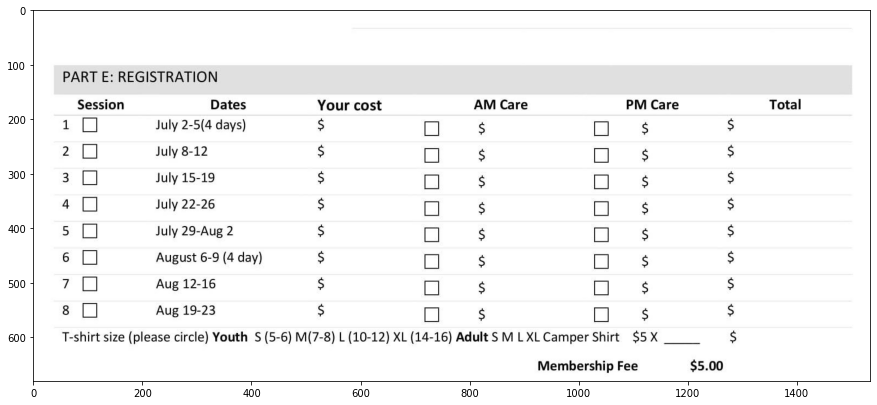

In [31]:
# example of boxes that we would like to detect
def plot(image,cmap=None):
    plt.figure(figsize=(15,15))
    plt.imshow(image,cmap=cmap) 
if plot_flag:
    plot(image)

#### Binarisation

In [28]:
gray_scale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
th1,img_bin = cv2.threshold(gray_scale,150,225,cv2.THRESH_BINARY)
img_bin

array([[225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       ...,
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225]], dtype=uint8)

In [29]:
img_bin=~img_bin
img_bin

array([[30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30],
       ...,
       [30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30]], dtype=uint8)

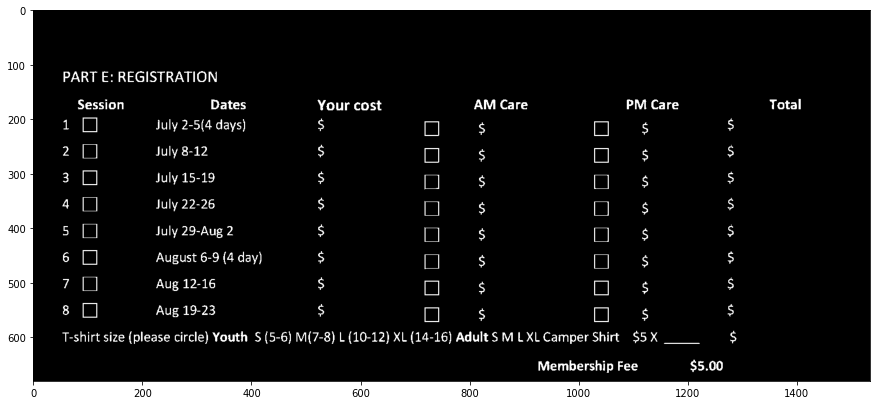

In [32]:
if plot_flag:
    plot(img_bin,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'bin_{image_path}'),img_bin)

#### Applying Morphological Operations

When solving Image processing problems, Morphological Transformation is a term you will come across many times.

We need to know these four terms; Dilation, Erosion, Opening, and Closing.

In simple terms,
*  Dilation: Makes the image thicker → Used to join broken parts
*  Erosion: Makes the image thinner → Used to remove noise, separate nearby components
*  Opening: Erosion then Dilation → Used in Noise removal
*  Closing: Dilation then Erosion → Filling small holes

In [34]:
line_min_width = 15 # size of the box in pixels or we can make it as a function
kernal_h = np.ones((1,line_min_width), np.uint8)
kernal_v = np.ones((line_min_width,1), np.uint8)

#### Applying Horizontal Kernel on the image

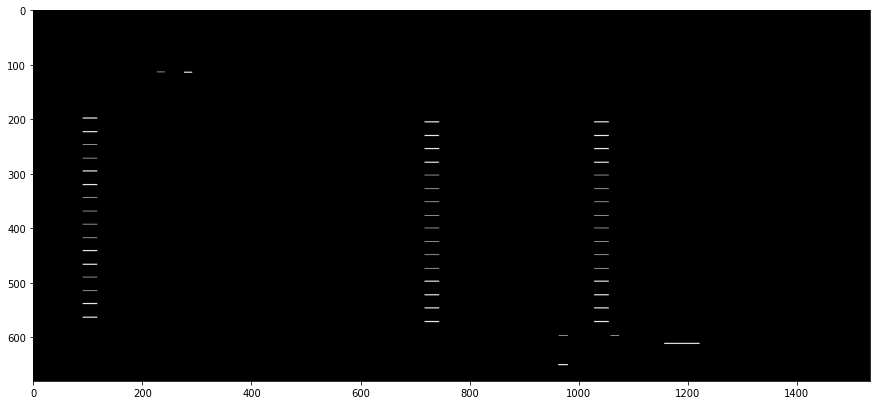

In [35]:
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
if plot_flag:
    plot(img_bin_h,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'hor_{image_path}'),img_bin_h)

#### Applying Vertical Kernel on the image

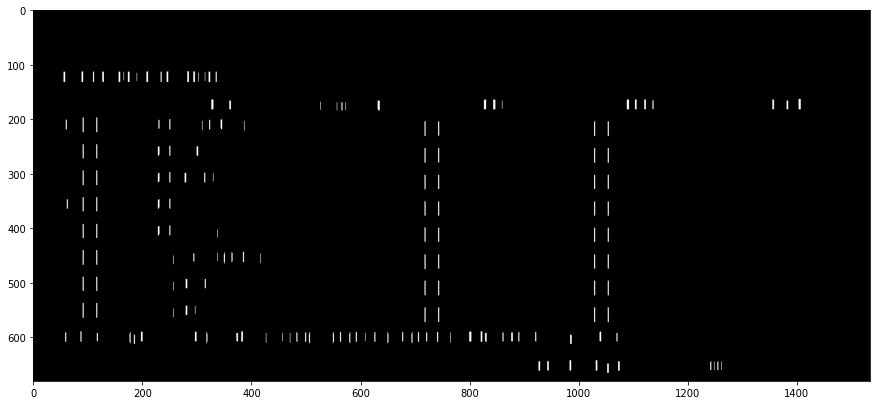

In [36]:
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
if plot_flag:
    plot(img_bin_v,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'ver_{image_path}'),img_bin_v)

#### Merging Horizontal and Vertical Images

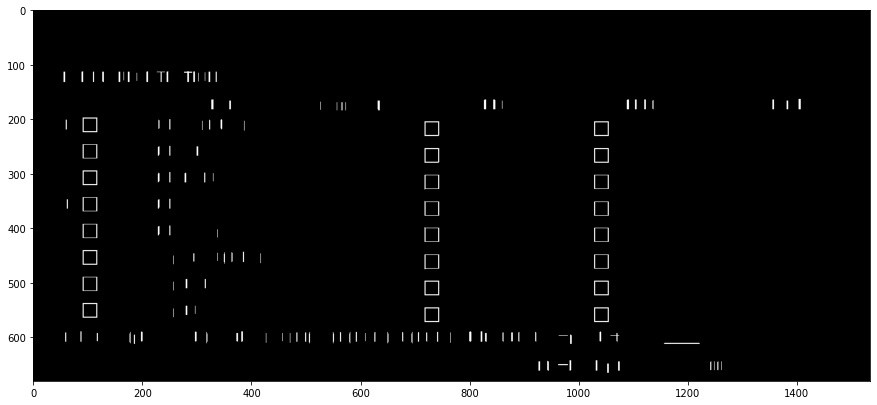

In [37]:
img_bin_final=img_bin_h|img_bin_v
if plot_flag:
    plot(img_bin_final,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'merge_{image_path}'),img_bin_final)

#### Adding a layer of dilation to close small gaps

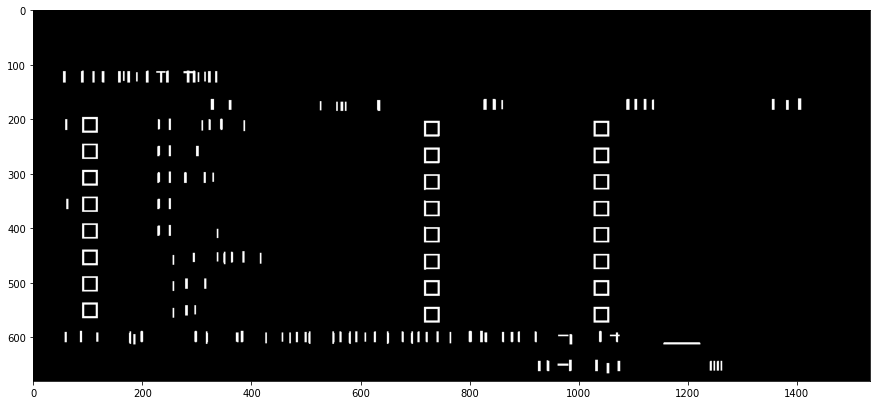

In [38]:
final_kernel = np.ones((3,3), np.uint8)
img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
if plot_flag:
    plot(img_bin_final,'gray')
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'final_bin_{image_path}'),img_bin_final)

#### Inverting the image and finding the connected components

In [39]:
ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)

In [40]:
### lets visualise the connected component image using the function

def imshow_components(labels):
    ### creating a hsv image, with a unique hue value for each label
    label_hue = np.uint8(179*labels/np.max(labels))
    ### making saturation and volume to be 255
    empty_channel = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, empty_channel, empty_channel])
    ### converting the hsv image to BGR image
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue==0] = 0
    ### returning the color image for visualising Connected Componenets
    return labeled_img

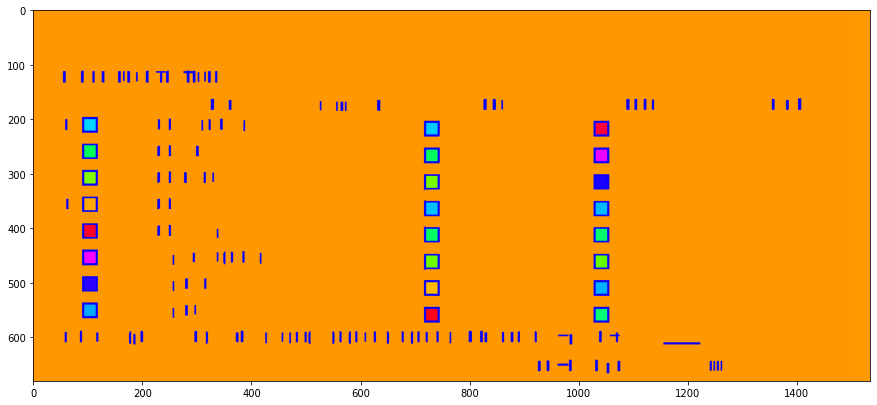

In [41]:
out_image=imshow_components(~labels)
if plot_flag:
    plot(out_image)
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'cc_{image_path}'),out_image)

We can see that all the checkboxes have been detected and assigned with a color.

#### Now, we can loop through each checkbox and draw a bounding box on them

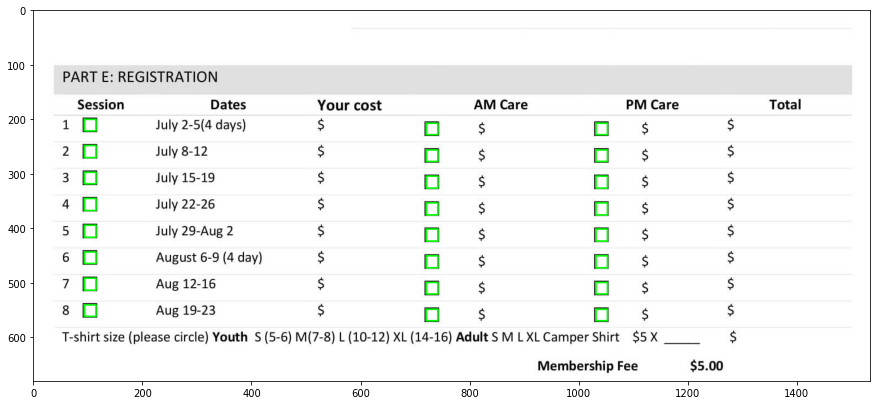

In [42]:
### skipping the first 2 labels
### 1 and 0 and the background and residue connected components whihc we do not require
for x,y,w,h,area in stats[2:]:
#     cv2.putText(image,'box',(x-10,y-10),cv2.FONT_HERSHEY_SIMPLEX, 1.0,(0,255,0), 2)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
if plot_flag:
    plot(image)
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'output_{image_path}'),image)

#### Test on ASB salary switch form

In [43]:
def detect_box(image,line_min_width=15):
    gray_scale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    th1,img_bin = cv2.threshold(gray_scale,150,225,cv2.THRESH_BINARY)
    kernal6h = np.ones((1,line_min_width), np.uint8)
    kernal6v = np.ones((line_min_width,1), np.uint8)
    img_bin_h = cv2.morphologyEx(~img_bin, cv2.MORPH_OPEN, kernal6h)
    img_bin_v = cv2.morphologyEx(~img_bin, cv2.MORPH_OPEN, kernal6v)
    img_bin_final=img_bin_h|img_bin_v
    final_kernel = np.ones((3,3), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
    ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    return stats,labels

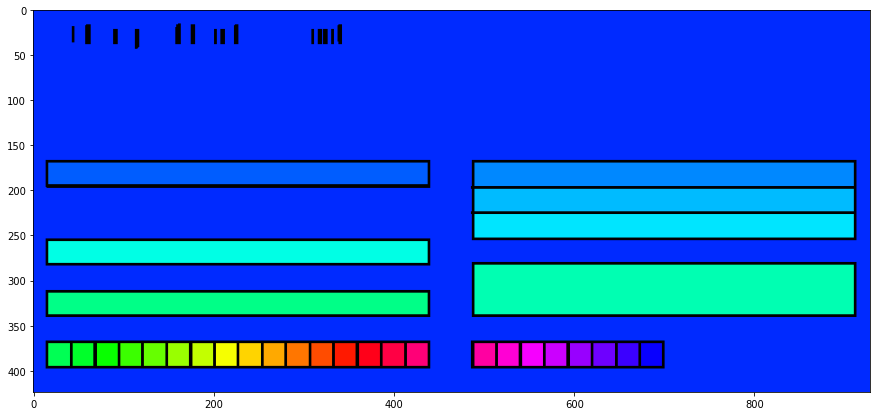

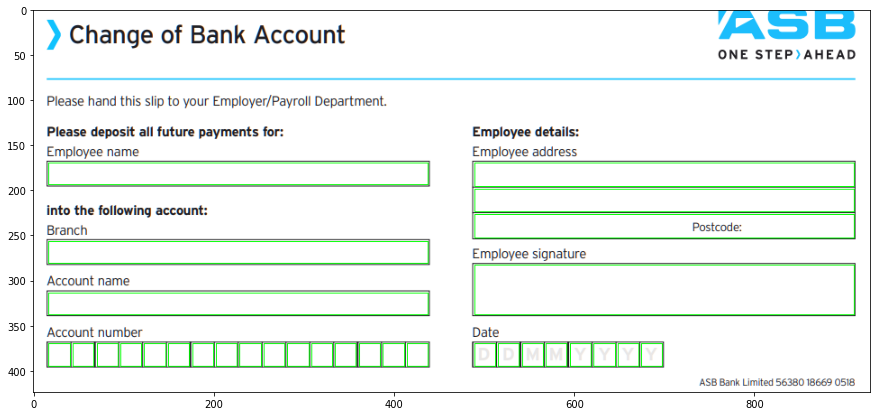

In [47]:
image_path = '/content/ASB_salary_switch.PNG'
image = cv2.imread(image_path)
stats,labels = detect_box(image)
cc_out=imshow_components(labels)

for x,y,w,h,area in stats[2:]:
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),1)

if plot_flag:
    plot(cc_out)
    plot(image) 
if save_output:
    cv2.imwrite(os.path.join(out_folder,f'cc_{image_path}'),cc_out)
    cv2.imwrite(os.path.join(out_folder,f'out_{image_path}'),image)

So how can we use these boxes? The logical next step is cropping the boxes using Coordinate Geometry and input them into OCR for content extraction,i.e. Whether it’s checked or not? What is the text content inside the box? Furthermore, we can store the information in a database for other usage.